In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pywt.data
import sys
import cv2

if '..' not in sys.path:
    sys.path.append('..')

from stego.transform import blocking, dwt
from stego import codec, correction_codes, message

In proposed MDLE-IWT method, 
1. IWT is first appliedto the cover image to obtain four wavelet coefficient sub-bands asembedding regions.
1. The embedding sub-bands order in the algorithm is HL, LH, HH, and LL. 
1. Next, the embedding sub-band is divided into 3×3 non-overlapping blocks
1. MDLE scheme is applied to each block


In [2]:
original = pywt.data.camera()
iwt = dwt.Iwt('haar', level=3)

In [3]:
iwt.forward(original)
secret_message = correction_codes.prepare_message("Apollo 17")

In [4]:
decimal_message = message.message_to_dec(secret_message)
detail_coefficients: list[np.ndarray] = list(iwt.coefficients[-1])
ll_coefficient = iwt.coefficients[0]

In [5]:

message_iterator = iter(decimal_message)

for band in [ll_coefficient] + detail_coefficients:
    blocks = blocking.divide_image(band, block_size=3)
    codec.encode_band(blocks, message_iterator)


In [6]:
iwt.coefficients[-1] = tuple(detail_coefficients)
iwt.coefficients[0] = ll_coefficient


stego_img = iwt.inverse()
stego_img.shape

(512, 512)

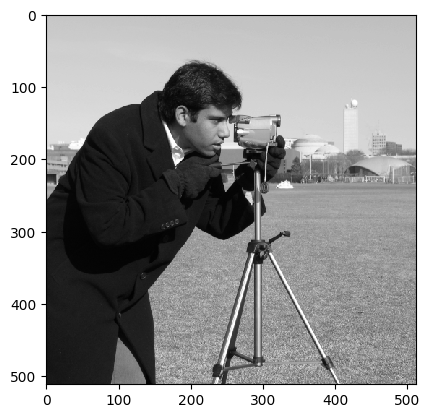

In [7]:

plt.imshow(stego_img, interpolation="nearest", cmap=plt.cm.gray)
# cv2.imwrite("comp.png", stego_img)
# img = cv2.imread("comp.png")
# stego_from_file, g, b = cv2.split(img)
# print(f"{np.allclose(stego_img, stego_from_file)=}")
# stego_img = stego_from_file
# plt.imshow(stego_img, interpolation="nearest", cmap=plt.cm.gray)
# stego_img.shape


## Extracting

In [8]:
stego_img = blocking.pad_image(stego_img, 3)
# extract
iwt.forward(stego_img)

detail_coefficients: list[np.ndarray] = list(iwt.coefficients[-1])
ll_coefficient = iwt.coefficients[0]


In [9]:
encoded_data = []

for band in [ll_coefficient] + detail_coefficients:
    blocks = blocking.divide_image(band, block_size=3)
    encoded_data += codec.decode_band(blocks)


In [10]:
message = message.dec_to_message(encoded_data)

In [11]:
print(f"{message[:255]=}")

message[:255]='JT4=?!*Ka͍}҃\x1a%\x07K^yx\x1d/\x07J \x13#q\x13HLa־4WEQ\x06(4\')AĂAv5"tM0HGO7b!\x18~|\x11A\x0bagϰ\x7fw\x11o\n!\x01b\x12f4D]\x0bk\tT\x1d\x01$\x04x3M\x00W\x0b,NFJ߂+=*o\x08&\\4z5I<\x05\x06gP\x05aږ)/\x1aئW((:Y\x0c\x1c\x06\x1b>e\x14X\x0b#\x08=9\nbcb~e\x059ui"us$\x11x\t/\uf8da8o&G\\yc2t~`Dߣv\x15xeꆬͭ;ʂʇH!4/u6\x02Nq|\x0e\x0e-\x7f_\x14K8qoF\x04h}El<R\nҚK^\x079L|%ǽe\U00098dfd\'U\x15%PzDE\nX\x12\x106\'EsԔ\x1fi\x0e(wD\\qH_\x16ғ\x02y[c3nF'


In [12]:
correction_codes.decode_message(message[:255])

IndexError: array index out of range